In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
df_train_txt = pd.read_csv('input/training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_train_txt.head()
# pandas .head() print the first 5 lines of data

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [3]:
df_train_var = pd.read_csv('input/training_variants')
df_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
df_test_txt = pd.read_csv('input/test_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_test_txt.head()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [5]:
df_test_var = pd.read_csv('input/test_variants')
df_test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [6]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()
# join two tables together, left(var) right(txt)
# how: The how argument to merge specifies how to determine which keys are to be included in the resulting table.
#left	LEFT OUTER JOIN	Use keys from left frame only
#right	RIGHT OUTER JOIN	Use keys from right frame only
#outer	FULL OUTER JOIN	Use union of keys from both frames
#inner	INNER JOIN	Use intersection of keys from both frames
# on: Columns (names) to join on. Must be found in both the left and right DataFrame objects. 


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
df_test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [8]:
df_train.describe(include='all')
#Generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.


,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [9]:
df_test.describe(include='all')

,ID,Gene,Variation,Text
count,5668.000000,5668,5668,5668
unique,NaN,1397,5628,5611
top,NaN,F8,Truncating Mutations,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,134,18,6
mean,2833.500000,NaN,NaN,NaN
std,1636.354994,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1416.750000,NaN,NaN,NaN
50%,2833.500000,NaN,NaN,NaN
75%,4250.250000,NaN,NaN,NaN


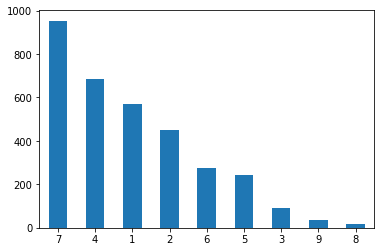

In [10]:
df_train['Class'].value_counts().plot(kind="bar", rot=0)
#plot df_train column 'class', from class 0 to 9, most doc belongs to class 7.
#the distribution of data is uneven.

In [11]:
# This cell reduces the training data for Kaggle limits. Remove this cell for real results.
#df_train, _ = train_test_split(df_train, test_size=0.7, random_state=8, stratify=df_train['Class'])
#df_train.shape

In [12]:
#used below to print loss and accuracy of ML model
#Generate cross-validated estimates for each input data point
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 0.34530691380008344
Accuracy: 0.9466666666666667


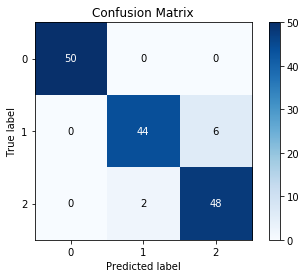

In [13]:
# This part can be deleted
# Quick test of evaluate_features
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True))

In [14]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    
# Convert a collection of text documents to a matrix of token counts.
# analyzer : string, {‘word’, ‘char’, ‘char_wb’} or callable.
# tokenizer : callable or None (default)
# Override the string tokenization step while preserving the preprocessing and n-grams generation steps. Only applies if analyzer == 'word'.
# stop_words : string {‘english’}, list, or None (default) If ‘english’, a built-in stop word list for English is used.


In [15]:
#nltk.download()
bag_of_words = count_vectorizer.fit_transform(df_train['Text'])
# two function together, fit and transform, fit is used to generate learning model parameters from training data
# transform(): using parameters generated from fit() method,applied upon model to generate transformed data set.

In [16]:
len(count_vectorizer.get_feature_names())
#feature name is more than kernel code 157768
# there are 285337 different words in the training data 'text' column

285337

In [17]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)
# Dimensionality reduction using truncated SVD
# n_components : int, default = 2
# Desired dimensionality of output data. Must be strictly less than the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended.
# n_iter : int, optional (default 5)
# Number of iterations for randomized SVD solver. 
# random_state : int, RandomState instance or None, optional, default = None
# If int, random_state is the seed used by the random number generator

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 2.2609225914083257
Accuracy: 0.3137609153869316


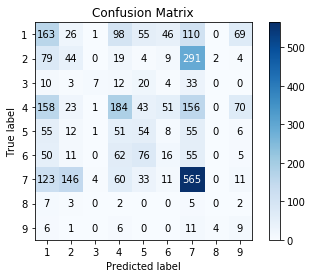

In [19]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel())

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.7319560019242972
Accuracy: 0.338452273411623


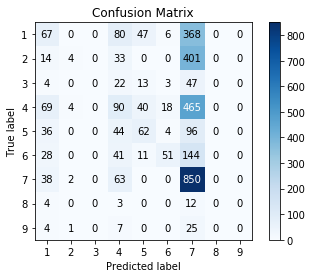

In [20]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [21]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(df_train['Text'])

len(count_vectorizer.get_feature_names())


285337

In [22]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.6913660315436716
Accuracy: 0.37548931044866


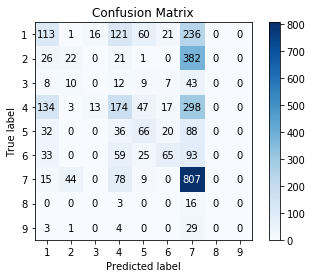

In [23]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel())

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.7051464053728278
Accuracy: 0.36133694670280037


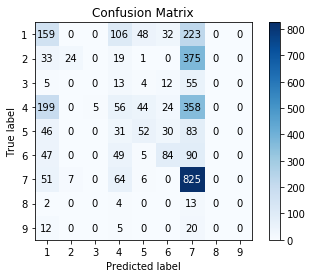

In [24]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.5min finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.9377405807031063
Accuracy: 0.30412526347485697


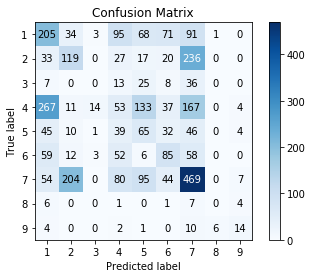

In [25]:
evaluate_features(tfidf, df_train['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))


In [26]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [27]:
w2vec = get_word2vec(
    MySentences(
        df_train['Text'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


In [28]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [29]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train['Text'])

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5466851051154975
Accuracy: 0.4360132490213791


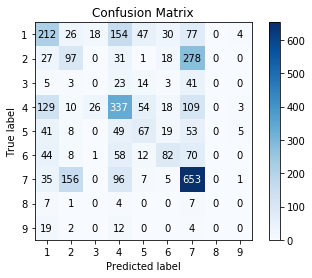

In [31]:
evaluate_features(mean_embedded, df_train['Class'].values.ravel())

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.8932373197265258
Accuracy: 0.42306534176452876


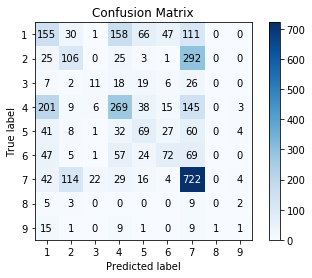

In [32]:
evaluate_features(mean_embedded, df_train['Class'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.8s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.6449689553314144
Accuracy: 0.4290876242095754


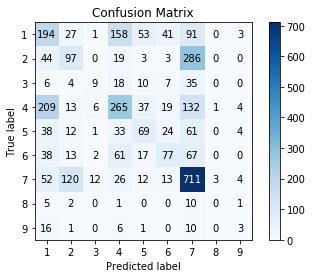

In [33]:
evaluate_features(mean_embedded, 
                  df_train['Class'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

In [34]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train['Text'].values)

In [36]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_train['Text'].values)
X = pad_sequences(X, maxlen=2000)

In [37]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
Y = pd.get_dummies(df_train['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(2656, 2000) (2656, 9)
(665, 2000) (665, 9)


In [39]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Train on 2124 samples, validate on 532 samples
Epoch 1/8
2124/2124 [==============================] - 464s - loss: 1.8736 - categorical_crossentropy: 1.8736 - val_loss: 1.7906 - val_categorical_crossentropy: 1.7906
Epoch 2/8
2124/2124 [==============================] - 473s - loss: 1.5509 - categorical_crossentropy: 1.5509 - val_loss: 1.4858 - val_categorical_crossentropy: 1.4858
Epoch 3/8
2124/2124 [==============================] - 437s - loss: 1.2480 - categorical_crossentropy: 1.2480 - val_loss: 1.3422 - val_categorical_crossentropy: 1.3422
Epoch 4/8
2124/2124 [==============================] - 459s - loss: 1.0467 - categorical_crossentropy: 1.0467 - val_loss: 1.2933 - val_categorical_crossentropy: 1.2933
Epoch 5/8
2124/2124 [==============================] - 461s - loss: 0.9086 - categorical_crossentropy: 0.9086 - val_loss: 1.3252 - val_categorical_crossentropy: 1.3252
Epoch 6/8
2124/2124 [==============================] - 434s - loss: 0.8035 - categorical_crossentropy: 0.8035 - v

In [40]:
model = load_model('keras_model')

In [41]:
probas = model.predict(X_test)

Log loss: 1.3514486911335497
Accuracy: 0.5323308270676692


/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


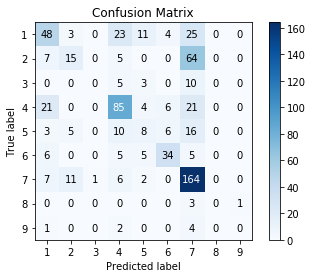

In [46]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

In [47]:
gene_le = LabelEncoder()
gene_encoded = gene_le.fit_transform(df_train['Gene'].values.ravel()).reshape(-1, 1)
gene_encoded = gene_encoded / np.max(gene_encoded)



In [48]:
variation_le = LabelEncoder()
variation_encoded = variation_le.fit_transform(df_train['Variation'].values.ravel()).reshape(-1, 1)
variation_encoded = variation_encoded / np.max(variation_encoded)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.6971860186886722
Accuracy: 0.38000602228244507


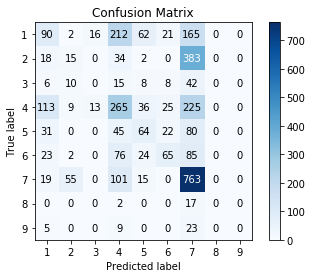

In [49]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train['Class'])

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.6777899346777998
Accuracy: 0.36224028906955735


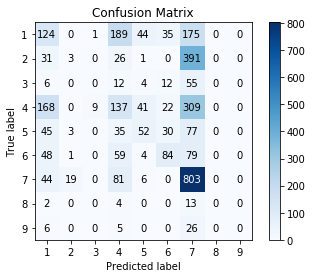

In [50]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5622870611880086
Accuracy: 0.42396868413128574


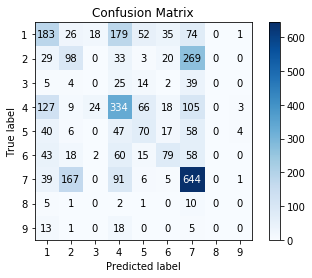

In [51]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, mean_embedded)), df_train['Class'])

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.575927144244132
Accuracy: 0.45347786811201446


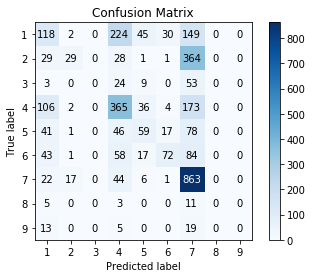

In [52]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, mean_embedded)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [53]:
one_hot_gene = pd.get_dummies(df_train['Gene'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)


In [54]:
one_hot_variation = pd.get_dummies(df_train['Variation'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.8281396661654143
Accuracy: 0.329418849744053


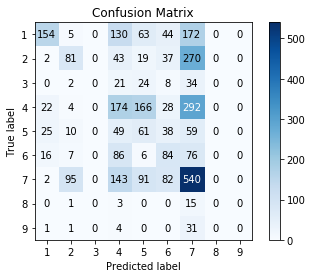

In [55]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train['Class'])

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.6981290954052162
Accuracy: 0.3676603432700994


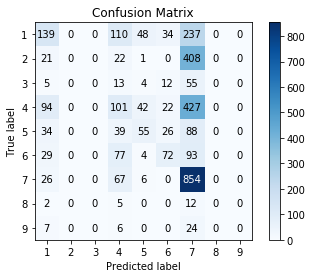

In [56]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.673565961980706
Accuracy: 0.43179765130984643


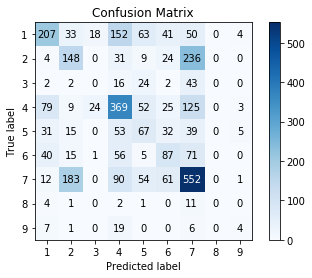

In [57]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, mean_embedded)), df_train['Class'])

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5798836394041624
Accuracy: 0.4712436013249021


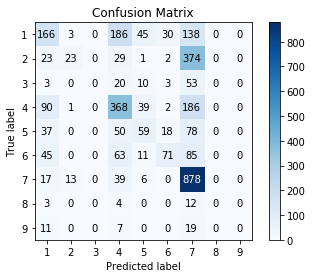

In [58]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, mean_embedded)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [59]:
#best output from here
lr_w2vec = LogisticRegression()
lr_w2vec.fit(mean_embedded, df_train['Class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
mean_embedded_test = mean_embedding_vectorizer.transform(df_test['Text'])

In [61]:
probas = lr_w2vec.predict_proba(mean_embedded_test)

In [62]:
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.021906,0.260258,0.025532,0.037171,0.014496,0.014060,0.619376,0.003934,0.003267,0
1,0.246271,0.051523,0.004041,0.524912,0.013335,0.035537,0.097325,0.012900,0.014156,1
2,0.075440,0.148312,0.006621,0.040908,0.012602,0.069070,0.614850,0.011613,0.020585,2
3,0.015280,0.277146,0.008694,0.076291,0.031112,0.012365,0.556648,0.008343,0.014124,3
4,0.181918,0.123197,0.007945,0.466626,0.009171,0.045566,0.148786,0.007629,0.009162,4


In [63]:
submission_df.to_csv('submission.csv', index=False)

In [64]:
xgb_w2vec = XGBClassifier(max_depth=4,
                          objective='multi:softprob',
                          learning_rate=0.03333)
xgb_w2vec.fit(mean_embedded, df_train['Class'])
probas = xgb_w2vec.predict_proba(mean_embedded_test)
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.to_csv('submission.csv', index=False)

In [65]:
svc_w2vec = SVC(kernel='linear', probability=True)
svc_w2vec.fit(mean_embedded, df_train['Class'])
probas = svc_w2vec.predict_proba(mean_embedded_test)
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.to_csv('submission.csv', index=False)

In [66]:
Xtest = tokenizer.texts_to_sequences(df_test['Text'].values)
Xtest = pad_sequences(Xtest, maxlen=2000)

In [67]:
probas = model.predict(Xtest)

In [68]:
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.140688,0.116418,0.016105,0.100922,0.048866,0.056093,0.502647,0.008356,0.009905,0
1,0.026734,0.270430,0.009395,0.014853,0.016235,0.028455,0.623277,0.004800,0.005823,1
2,0.129527,0.069944,0.014134,0.473569,0.021769,0.015545,0.267012,0.004073,0.004426,2
3,0.158945,0.102054,0.010664,0.124643,0.028557,0.017664,0.547256,0.004570,0.005648,3
4,0.196746,0.061452,0.020841,0.517080,0.042463,0.013907,0.135631,0.005506,0.006373,4


In [69]:
submission_df.to_csv('submission.csv', index=False)